# Evaluation of previous CC teams' solutions

## Imports

In [1]:
from collections import namedtuple
import datetime
from pathlib import Path
import sys
import warnings

sys.path.append(str(Path(sys.path[0]) / "agile_snails_coding_challenge"))

# The Agile Snails code uses a lot of deprecated features and spews hundreds of warnings
# Silence those so we can focus on the actual output
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

# A nice progress bar while we wait for the Agile Snails model to run
from tqdm.notebook import tqdm

In [3]:
from team_7564616d_models import team_7564616d_interface
from agile_snails_coding_challenge import agile_snails_interface

# Structure the two wrappers so they can easily be iterated over by the same code

Team = namedtuple("Team", ["name", "interface", "volume_correction"])

teams = [
    Team("Team 7564616D", team_7564616d_interface, 0.001),
    Team("Agile Snails", agile_snails_interface, 1),
]

In [4]:
# There's a bug in the Agile Snails interface
# such that it doesn't work correctly unless the current directory is
# the root of their repository
# For now, we can work around that by littering their repository
# If it were going to be used going forward, that should be fixed.

%cd agile_snails_coding_challenge/

/Users/ed/src/cc2022/agile_snails_coding_challenge


In [5]:
from types import ModuleType
from typing import Any

# poor man's way of type hinting for pd.DataFrames
# these details are not enforced by type checkers
# for production code better use something like
# https://github.com/CedricFR/dataenforce

Bid = pd.DataFrame  # with columns: effective_date, hour_id, quantity, price
HourlyData = pd.DataFrame  # with columns: time_period [in hours], ...
HalfHourlyData = pd.DataFrame  # with columns: time_period [in half hours], ...

## Get teams' bids

In [6]:
start_date = datetime.date(2021, 1, 1)
end_date = datetime.date(2022, 12, 31)

In [7]:
def get_team_bids(
    interface: ModuleType,
    start_date: datetime.date,
    end_date: datetime.date,
    use_cache: bool = False,
    price_correction: float = 1.0,
    volume_correction: float = 1.0,
) -> HourlyData:
    """Get the bids from the API wrapper `interface`
    for each date between `start_date` and `end_date`.
    Try and use cached data if they exist.
    Also, correct for any misscalings in the volume."""

    cache_filename = f"{interface.__name__}.csv"

    if use_cache and Path(cache_filename).is_file():
        bids = pd.read_csv(cache_filename)
        bids.effective_date = pd.to_datetime(bids.effective_date)
    else:
        bids = get_team_bids_raw(interface, start_date, end_date)
        bids.to_csv(cache_filename, index=False)

    bids["price"] *= price_correction
    bids["quantity"] *= volume_correction

    # For convenience, add a datetime column referring to the specific hour
    bids["time_period"] = bids["effective_date"] + bids["hour_id"].map(
        lambda hour: datetime.timedelta(hours=hour - 1)
    )

    return bids


def get_team_bids_raw(
    interface: ModuleType, start_date: datetime.date, end_date: datetime.date
) -> Bid:
    """Get the bids from the API wrapper `interface`
    for each date between `start_date` and `end_date`."""
    bids = []
    for date in tqdm(pd.date_range(start_date, end_date)):
        effective_date = date + datetime.timedelta(days=1)
        try:
            bid = sanitize_bid(interface.get_price_and_quantity(date))
            bid["effective_date"] = effective_date

        # Never do the following in production code: This will catch any Exception
        # including KeyboardInterrupt and any weird error, you never thought could
        # happen! This implies that, e.g., if this was running from a console you
        # wouldn't even be able to shut this down by CTRL-C.
        # In this specific case, we use it to simulate the real bidding process:
        # If literally any exception occurs, there won't be a valid bid and
        # time goes on.
        except Exception:
            # If anything goes wrong, record a null datum instead
            bid = pd.DataFrame(
                [
                    {
                        "effective_date": effective_date,
                        "hour_id": 0,
                        "quantity": None,
                        "price": None,
                    }
                ]
            )
        bids.append(bid)

    # Return a single DataFrame
    return pd.concat(bids, ignore_index=True)


def sanitize_bid(bid: Bid) -> Bid:
    """Ensure that bids are formatted in a useful form for further processing,
    and approximate what the API would do in terms of dropping invalid bids."""

    # Turn the index column into an "hour_id" column, so that concatenation works
    if not (index_name := bid.index.name):
        index_name = "index"
    bid = bid.reset_index().rename(columns={index_name: "hour_id"})

    # Each bid is for a 1-hour timeslot;
    # we cannot have a day longer than 24 hours
    # (Our fake market operates on GMT exclusively)
    return bid[(bid.hour_id >= 0) & (bid.hour_id < 24)]


team_bids = {}

for team_name, interface, *_ in teams:
    print(f"Getting {team_name} predictions")
    team_bids[team_name] = get_team_bids(
        interface, start_date, end_date, use_cache=True
    )

Getting Team 7564616D predictions
Getting Agile Snails predictions


## Get historical data

In [8]:
data_dir = Path("..") / "coding_challenge_2022-23_data"


def is_bst(date: pd.Timestamp) -> bool:
    """Check if given date is British summer time or not."""
    return (
        (date > datetime.date(2022, 3, 27)) and (date <= datetime.date(2022, 10, 30))
    ) or ((date > datetime.date(2021, 3, 28)) and (date <= datetime.date(2021, 10, 31)))


def convert_to_time_period(
    date: pd.Timestamp, period: int, periods_per_hour: int = 1
) -> pd.Timestamp:
    """Convert a given date and period to a time period."""
    correction_for_market_starting_at_11pm = -1
    correction_for_bst = -1 if is_bst(date) else 0
    return date + datetime.timedelta(
        hours=period / periods_per_hour
        + correction_for_bst
        + correction_for_market_starting_at_11pm
    )


# Get the imbalance market prices
imbalance_prices = pd.read_csv(data_dir / "imbalance_prices.csv")
imbalance_prices.date = pd.to_datetime(imbalance_prices.date)


# Imbalance prices are in half-hour periods
imbalance_prices["time_period"] = imbalance_prices.apply(
    lambda df: convert_to_time_period(df.date, df.period - 1, periods_per_hour=2),
    axis=1,
)
imbalance_prices = imbalance_prices.sort_values(by="time_period")

# Get the day-ahead market prices
market_index = pd.read_csv(data_dir / "market_index.csv")
market_index.date = pd.to_datetime(market_index.date)
# Market data numbers periods starting from 1, not 0
market_index["time_period"] = market_index.apply(
    lambda df: convert_to_time_period(df.date, df.period - 1), axis=1
)
market_index = market_index.sort_values(by="time_period")


# Fake the volume data for now
def get_volumes() -> HalfHourlyData:
    """Given the Agile Snails data, get the quantity and split it into half hours.
    This gives an approximation of what actual volume data may look like."""
    return split_hours(team_bids["Agile Snails"][["time_period", "quantity"]])


# For now, assume that each volume committed is divided evenly between two half-hour blocks
def split_hours(data: HourlyData) -> HalfHourlyData:
    """Given a DataFrame `data` with data having an hourly `time_period` column,
    split each row into two half-hourly periods,
    and divide the `quantity` column by two."""
    data = data.set_index("time_period").asfreq("30min", method="pad")
    return data.assign(quantity=0.5 * data["quantity"]).reset_index()


volumes = get_volumes()

## Comparing the day-ahead and imbalance markets

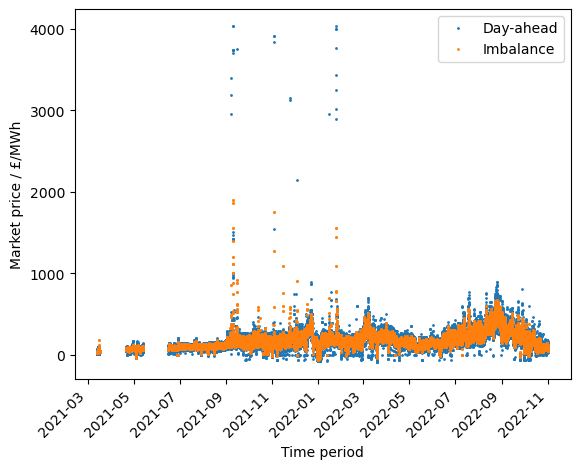

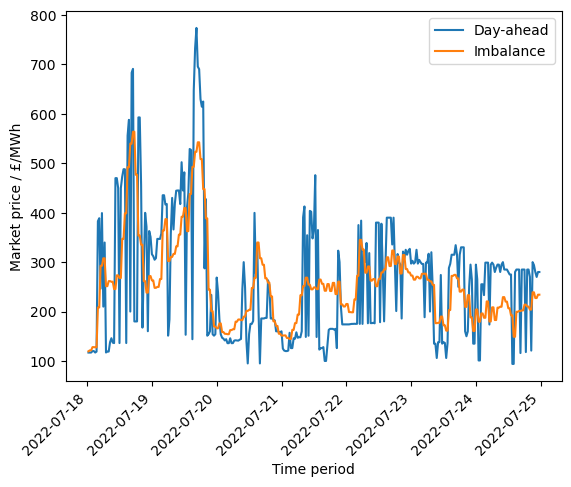

In [9]:
def get_representative_time_period(data: HalfHourlyData) -> HalfHourlyData:
    """Strip given data down to a small representative time period on which short term changes can be observed."""
    return data[
        (data["time_period"] > pd.Timestamp("2022-07-18"))
        * (data["time_period"] < pd.Timestamp("2022-07-25"))
    ]


markets = pd.merge(
    imbalance_prices,
    split_hours(market_index.rename(columns={"volume": "quantity"})),
    on="time_period",
    suffixes=["_market", "_imbalance"],
).sort_values(by="time_period")


def plot_markets(
    markets: HalfHourlyData,
    # CAUTION: Mutable-type default arguments are mutable!
    # Mutating the style dict inside of the function (or 
    # via some twisted other route), e.g. with
    # style.update(...) will persist between calls.
    style: dict[str, Any] = dict(
        marker="o",
        markersize=1,
        linestyle="none",
    ),
) -> None:
    """Plot behavior of the markets in the reference data."""
    fig, ax = plt.subplots()

    ax.plot(markets["time_period"], markets["price_market"], label="Day-ahead", **style)
    ax.plot(
        markets["time_period"], markets["price_imbalance"], label="Imbalance", **style
    )

    ax.set_xlabel("Time period")
    ax.set_ylabel("Market price / £/MWh")
    ax.set_xticklabels(ax.get_xticklabels(), ha="right", rotation=45)

    ax.legend(loc="best")

    plt.show()


plot_markets(markets)
plot_markets(
    get_representative_time_period(markets), style={"linestyle": "-", "marker": "none"}
)

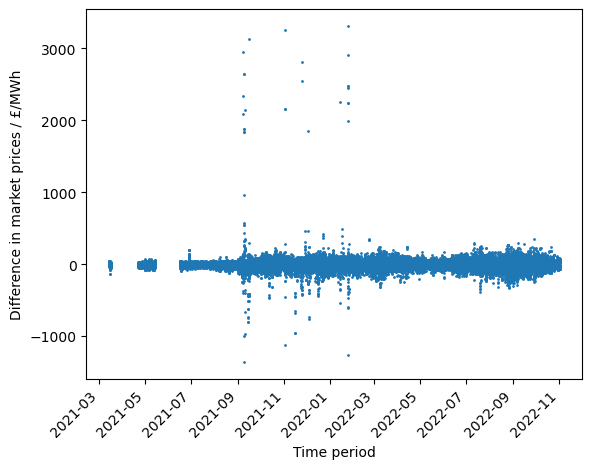

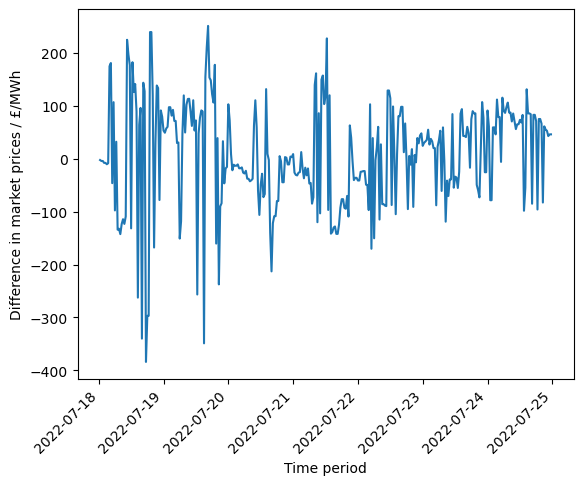

In [10]:
def plot_market_difference(
    markets: HalfHourlyData,
    style: dict[str, Any] = dict(
        marker="o",
        markersize=1,
        linestyle="none",
    ),
) -> None:
    """Plot difference between day-ahead and imbalance market."""
    fig, ax = plt.subplots()

    ax.plot(
        markets.time_period, markets.price_market - markets.price_imbalance, **style
    )

    ax.set_xlabel("Time period")
    ax.set_ylabel("Difference in market prices / £/MWh")
    ax.set_xticklabels(ax.get_xticklabels(), ha="right", rotation=45)

    plt.show()


plot_market_difference(markets)
plot_market_difference(
    get_representative_time_period(markets), style={"linestyle": "-", "marker": "none"}
)

In [11]:
print(
    f"Day-ahead is on average {(markets.price_market - markets.price_imbalance).mean() * 100:.02f}",
    "pence per MWh higher than imbalance market\nwhich is",
    f"{(markets.price_market - markets.price_imbalance).mean()/markets.price_market.mean() * 100:.2f}%",
    f"of the day-ahead market's average of {markets.price_market.mean():.2f} £/MWh.",
)

Day-ahead is on average 23.33 pence per MWh higher than imbalance market
which is 0.13% of the day-ahead market's average of 175.17 £/MWh.


## Compare historical data with predictions

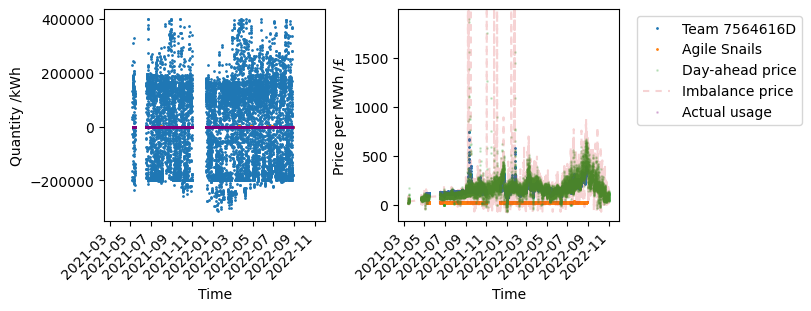

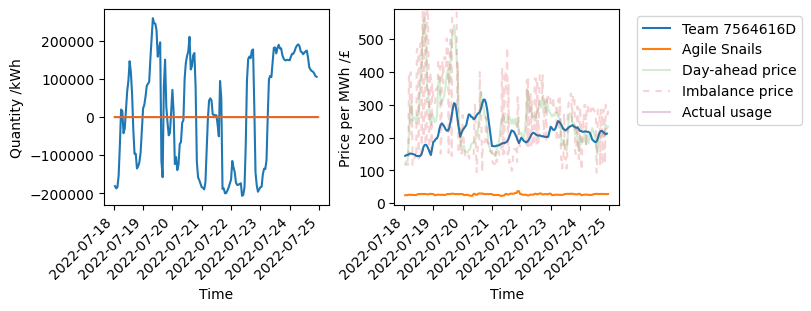

In [12]:
def plot_bids_market_comparison(
    team_bids: dict[str, HalfHourlyData],
    market_index: HalfHourlyData,
    imbalance_prices: HalfHourlyData,
    volumes: HalfHourlyData,
    style: dict[str, Any] = dict(
        marker="o",
        markersize=1,
        linestyle="none",
    ),
) -> None:
    """Given the bids made by the teams, and the data for the day-ahead and imbalance markets,
    generate comparison plots of the teams' bids with the market values and actual volumes.
    """

    # TODO: In addition to line graphs, make bar plots showing data per month.

    fig, axes = plt.subplots(ncols=2, figsize=(8, 3), sharex=True, layout="constrained")

    handles = []

    # Plot data for teams
    for team_name, bids in team_bids.items():
        axes[0].plot(bids.time_period, bids.quantity, **style)
        handles.append(
            axes[1].plot(bids.time_period, bids.price, label=team_name, **style)
        )

    # Add actual market data for comparison
    handles.append(
        axes[1].plot(
            market_index.time_period,
            market_index.price,
            label="Day-ahead price",
            alpha=0.2,
            **style
        )
    )

    # Limit y-axis now so that imbalance prices don't completely throw out the scale
    axes[1].set_ylim(None, None)

    handles.append(
        axes[1].plot(
            imbalance_prices.time_period,
            imbalance_prices.price,
            dashes=(3, 3),
            alpha=0.2,
            label="Imbalance price",
        )
    )

    # Add actual usage
    handles.append(
        axes[0].plot(
            volumes.time_period,
            volumes.quantity,
            color="purple",
            label="Actual usage",
            alpha=0.2,
            **style
        )
    )

    for ax in axes:
        ax.set_xlabel("Time")
        ax.set_xticklabels(ax.get_xticklabels(), ha="right", rotation=45)

    axes[0].set_ylabel("Quantity /kWh")
    axes[1].set_ylabel("Price per MWh /£")

    axes[1].legend(
        handles=[handle[0] for handle in handles],
        loc="upper left",
        bbox_to_anchor=(1.05, 1),
    )

    plt.show()


plot_bids_market_comparison(team_bids, market_index, imbalance_prices, volumes)
plot_bids_market_comparison(
    {key: get_representative_time_period(value) for key, value in team_bids.items()},
    get_representative_time_period(market_index),
    get_representative_time_period(imbalance_prices),
    get_representative_time_period(volumes),
    style={"linestyle": "-", "marker": "none"},
)

## Bugs

* The Team 7564616D volume data is way off the market—it looks like the units are wrong (Wh instead of kWh). It's more interesting to see how things perform if we were able to fix that bug.
* The Agile Snails price data is well below the market, but there is no obvious relation or way to fix that.

In [13]:
team_bids_corrected = {}

for team_name, interface, volume_correction in teams:
    print(f"Getting {team_name} predictions")
    team_bids_corrected[team_name] = get_team_bids(
        interface,
        start_date,
        end_date,
        use_cache=True,
        volume_correction=volume_correction,
    )

Getting Team 7564616D predictions
Getting Agile Snails predictions


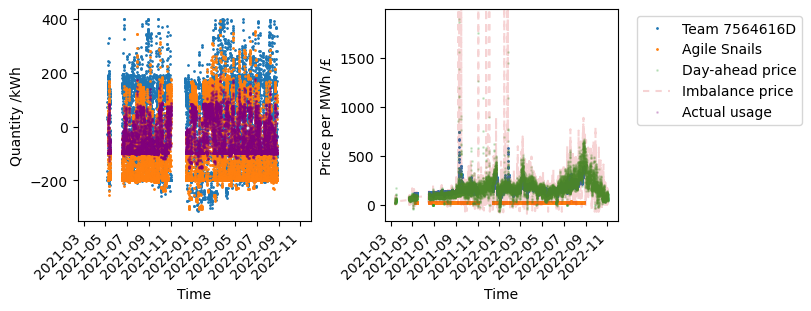

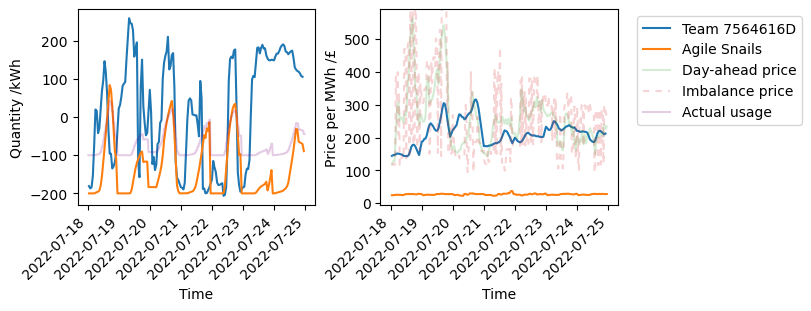

In [14]:
plot_bids_market_comparison(
    team_bids_corrected,
    market_index,
    imbalance_prices,
    volumes,
)
plot_bids_market_comparison(
    {
        key: get_representative_time_period(value)
        for key, value in team_bids_corrected.items()
    },
    get_representative_time_period(market_index),
    get_representative_time_period(imbalance_prices),
    get_representative_time_period(volumes),
    style={"linestyle": "-", "marker": "none"},
)

The two teams now seem to be a similar order of magnitude in quantity.
Agile Snails are consistently more pessimistic than Team 7564616D.

## Compute net income

In [15]:
kWh_per_MWh = 1000


def get_combined_historical_data(
    market_index: HourlyData,
    imbalance_prices: HalfHourlyData,
    volumes: HalfHourlyData,
) -> HalfHourlyData:
    """Given historical data for the day-ahead (`market_index`) and imbalance (`imbalance_prices`) markets,
    and the historical usage of the site (`volumes`),
    return a single wide DataFrame combining the three."""

    market = pd.merge(
        split_hours(
            market_index.rename(columns={"volume": "quantity"}).drop(
                columns=["date", "period"]
            )
        ),
        imbalance_prices.drop(columns=["date", "period"]),
        on="time_period",
        suffixes=["_market", "_imbalance"],
    ).drop(columns=["quantity"])

    return pd.merge(market, volumes, on="time_period")


def combine_team_data(bids: HourlyData, historical: HalfHourlyData) -> HalfHourlyData:
    """Given a team's `bids` and a DataFrame of `historical` data, return the two combined
    into a single DataFrame."""

    bids_with_history = pd.merge(
        split_hours(bids), historical, on="time_period", suffixes=["_bid", "_actual"]
    )
    return bids_with_history.rename(columns={"price": "price_bid"})


def get_committed_production(bids_with_history: HalfHourlyData) -> HalfHourlyData:
    """Given a DataFrame of bids and the corresponding historical actual data
    `bids_with_history`,
    compute the production that is spoken for in the day-ahead auction each day,
    i.e. the market price times the bid volume."""

    accepted_bids = bids_with_history[
        bids_with_history.price_bid < bids_with_history.price_market
    ].copy()
    accepted_bids["committed_production"] = (
        accepted_bids.price_market * bids_with_history.quantity_bid
    )
    return accepted_bids


def get_net_income(bids_with_history: HalfHourlyData) -> HalfHourlyData:
    """Given a DataFrame of bids and the corresponding historical actual data
    `bids_with_history`,
    compute the net income for each time period,
    and return a copy of `bids_with_history` with these data added as a `net_income` column.
    """

    local_bids = bids_with_history.copy()
    committed_production = get_committed_production(bids_with_history)

    local_bids["net_income"] = (
        committed_production.quantity_bid * committed_production.price_market
        + (committed_production.quantity_actual - committed_production.quantity_bid)
        * committed_production.price_imbalance
    ) / kWh_per_MWh

    return local_bids[["time_period", "net_income"]]


def get_optimal_performance(historical: HalfHourlyData) -> HalfHourlyData:
    """Get an indicative optimal performance, assuming a perfect knowledge about whether
    the imbalance or day-ahead prices will be higher, and about our usage, but having a
    level of prudence where we do not speculate on more units than we will consume/produce.
    """

    def optimal_single_row(row: pd.Series) -> float:
        if row.quantity < 0:
            # TODO Add controllable amount of gambling that is permitted
            optimal_price = min(row.price_market, row.price_imbalance)
        else:
            optimal_price = max(row.price_market, row.price_imbalance)
        return row.quantity * optimal_price / kWh_per_MWh

    historical_local = historical.copy()
    historical_local["optimal_net_income"] = historical.apply(
        optimal_single_row, axis=1
    )
    return historical_local[["time_period", "optimal_net_income"]]

In [16]:
combined_history = get_combined_historical_data(market_index, imbalance_prices, volumes)

team_net_incomes = {}

for team_name, bids in team_bids_corrected.items():
    team_data = combine_team_data(bids, combined_history)
    team_net_incomes[team_name] = get_net_income(team_data)

optimal_performance = get_optimal_performance(combined_history)

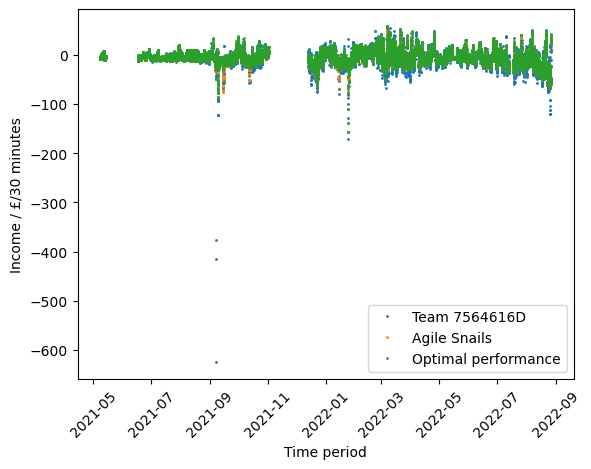

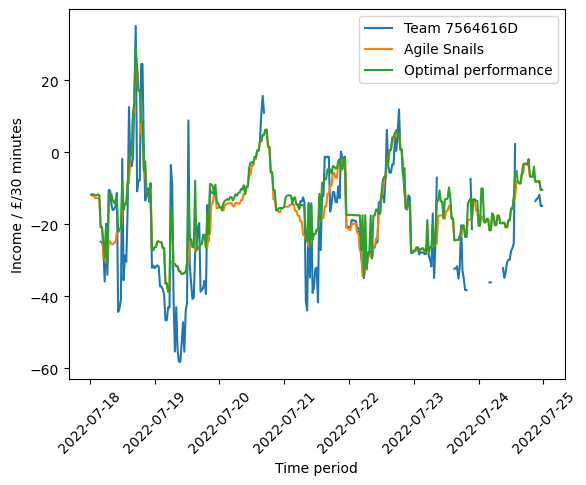

In [17]:
def plot_performance(
    team_net_incomes: dict[str, HalfHourlyData],
    optimal_performance: HalfHourlyData,
    style: dict[str, Any] = dict(
        marker="o",
        markersize=1,
        linestyle="none",
    ),
):
    """Plot the performance of the different teams together with the optimal performance."""
    fig, ax = plt.subplots()

    for team_name, net_income in team_net_incomes.items():
        ax.plot(net_income.time_period, net_income.net_income, label=team_name, **style)

    ax.plot(
        optimal_performance.time_period,
        optimal_performance.optimal_net_income,
        label="Optimal performance",
        **style
    )

    ax.set_xlabel("Time period")
    ax.set_ylabel("Income / £/30 minutes")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    ax.legend(loc="best")
    plt.show()


plot_performance(team_net_incomes, optimal_performance)
plot_performance(
    {
        key: get_representative_time_period(value)
        for key, value in team_net_incomes.items()
    },
    get_representative_time_period(optimal_performance),
    style={"linestyle": "-", "marker": "none"},
)

In [18]:
Pounds = float # another weak type hint
def format_currency(amount: Pounds) -> str:
    """Format given number as pounds."""
    sign = "" if amount >= 0 else "-"
    return f"{sign}£{abs(amount):.02f}"


print(
    f"Optimal income: {format_currency(optimal_performance.optimal_net_income.sum())}"
)

for team_name, net_income in team_net_incomes.items():
    print(f"{team_name} income: {format_currency(net_income.net_income.sum())}")

Optimal income: -£92834.83
Team 7564616D income: -£70423.78
Agile Snails income: -£123564.41


## Carbon savings

In [19]:
carbon_intensity = pd.read_csv(data_dir / "carbon-intensity.csv").rename(
    columns={"datetime": "time_period"}
)
carbon_intensity.time_period = pd.to_datetime(carbon_intensity.time_period)

In [20]:
def carbon_savings(
    carbon_intensity: HalfHourlyData, volumes: HalfHourlyData
) -> HalfHourlyData:
    """Given the `carbon_intensity` data for South Wales, and the `volume` exported,
    compute the carbon emissions or savings as a result of having the site
    for each time period for which there is data, in grams.

    NOTE: This is not the carbon savings of having the renewable energy installation;
    that would require having data on the total generation (or consumption)
    separate from the net export.

    Negative values indicate net carbon emissions rather than savings."""

    intensity_volume = pd.merge(carbon_intensity, volumes, on="time_period").dropna()
    # TODO: Interpolate missing data in grid carbon intensity rather than dropping

    intensity_volume["carbon_savings"] = (
        intensity_volume["South Wales"] * intensity_volume["quantity"]
    )
    return intensity_volume[["time_period", "carbon_savings"]]

In [21]:
print(
    "Total carbon savings as the result of opening the HQ for periods where data are available:",
    f"{sum(carbon_savings(carbon_intensity, volumes).carbon_savings) / 1e3:.0f}kg",
)

Total carbon savings as the result of opening the HQ for periods where data are available: -242184kg
